In [37]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import scipy
import pandas as pd
import uproot3 as ur
import tensorflow as tf
import atlas_mpl_style as ampl
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)

ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

# path_prefix = '/AL/Phd/maxml/'
# plotpath = path_prefix+'caloml-atlas/inputs/Plots/'
# modelpath = path_prefix+'caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# # metadata
# layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
# cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
# cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
# len_phi = [4, 16, 16, 4, 4, 4]
# len_eta = [128, 16, 8, 4, 4, 2]

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

print("Num GPUs Available: ", len(gpus))
tf.config.list_physical_devices()

Num GPUs Available:  1


/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:163: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
inputpath = "/clusterfs/ml4hep/mfong/ML4Pions/MLTreeData/"
inputpath_pi0 = inputpath + "user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/"
inputpath_pion = inputpath + "user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/"

branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta',
            'truthPhi', 'clusterIndex', 'nCluster', 'clusterE',
            'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi',
            'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT',
            'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT',
            'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT',
            'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG',
            'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
            'cluster_cell_dR_max', 'cluster_cell_dEta_min',
            'cluster_cell_dEta_max', 'cluster_cell_dPhi_min',
            'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta',
            'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer',
            'cluster_cellE_norm']
geo_branches = [
    'cell_geo_ID', 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi',
    'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi', 'cell_geo_volume',
    'cell_geo_sigma'
]

In [3]:
infile = ur.open(inputpath_pi0 + 'user.angerami.24559740.OutputStream._000011.root')

In [4]:
geo_df = infile['CellGeo'].pandas.df(geo_branches)
geo_df

# eta and phi angles
# rPerp distance in mm from center

# cell_geo_deta is size of cell
# cell_geo_dphi is size of cell
# cell_geo_volume is volume of cell

# cell_geo_sigma is noise

cell_geo_ID  cell_geo_sampling  cell_geo_eta  cell_geo_phi  \
entry subentry                                                               
0     0           740294656                  6     -2.559710      0.053900   
      1           740294658                  6     -2.559648      0.151909   
      2           740294660                  6     -2.559603      0.249912   
      3           740294662                  6     -2.559574      0.347912   
      4           740294664                  6     -2.559562      0.445909   
...                     ...                ...           ...           ...   
      187645     1284491536                 15      0.958372     -0.049087   
      187646     1284491824                 17      1.058902     -0.049087   
      187647     1284492080                 17      1.159304     -0.049087   
      187648     1284492592                 17      1.309847     -0.049087   
      187649     1284493104                 17      1.510363     -0.049087   

                cell_geo_rPerp  cell_geo_deta  cell_geo_dphi  cell_geo_volume  \
entry subentry                                                                  
0     0             617.735962            0.1       0.098175     1.697610e+06   
      1             617.774719            0.1       0.098175     1.697610e+06   
      2             617.803223            0.1       0.098175     1.697610e+06   
      3             617.821167            0.1       0.098175     1.697610e+06   
      4             617.828552            0.1       0.098175     1.697610e+06   
...                        ...            ...            ...              ...   
      187645       3215.000000            0.1       0.098175     1.346147e+07   
      187646       2809.000000            0.1       0.098175     1.341334e+06   
      187647       2477.000000            0.1       0.098175     1.241210e+06   
      187648       2060.000000            0.2       0.098175     7.739876e+05   
      187649       1640.000000            0.2       0.098175     4.666501e+05   

                cell_geo_sigma  
entry subentry                  
0     0              49.457161  
      1              49.457161  
      2              49.457161  
      3              49.457161  
      4              49.457161  
...                        ...  
      187645         20.233513  
      187646         10.413343  
      187647         10.957963  
      187648         12.509910  
      187649         11.231500  

[187650 rows x 9 columns]

In [5]:
df_all_cols = infile['EventTree'].pandas.df(flatten=False)
df = df_all_cols[['cluster_cell_ID', 'cluster_cell_E', 'cluster_Eta', 'cluster_Phi']]
df

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/awkward0/array/base.py:398: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return cls.numpy.array(value, copy=False)


cluster_cell_ID  \
entry                                                      
0                                                     []   
1      [[759192106, 759192104, 759192108, 759191594, ...   
2      [[751056134, 751056132, 751056136, 751055622, ...   
3      [[751053140, 751053138, 751053142, 751052628, ...   
4      [[749243440, 749243442, 749242928, 749243952, ...   
...                                                  ...   
19995  [[749757984, 749757986, 749757472, 749758496, ...   
19996  [[759180956, 759180954, 759180958, 759180444, ...   
19997  [[740295258, 740295256, 740295260, 740294746, ...   
19998  [[759177744, 759177742, 759177746, 759177232, ...   
19999  [[776213366, 776213364, 776213368, 776212854, ...   

                                          cluster_cell_E  \
entry                                                      
0                                                     []   
1      [[77.977806, 24.14488, 4.869435, 2.659961, 21....   
2      [[413.32898, 48.909393, 90.18763, 39.86163, 27...   
3      [[1.652616, 0.11616877, 0.71565634, 0.10801599...   
4      [[0.25986475, 0.048873316, 0.0951039, 0.186739...   
...                                                  ...   
19995  [[0.6816676, 0.008014569, 0.2565823, 0.3002508...   
19996  [[64.28961, 3.8230877, 12.329029, 2.738421, 3....   
19997  [[56.3288, 5.3618994, 7.271554, 1.4210855, 1.7...   
19998  [[48.33428, 38.986496, 1.816141, 5.113716, 2.3...   
19999  [[0.55646944, 0.15287827, 0.1772097, 0.2801490...   

                    cluster_Eta               cluster_Phi  
entry                                                      
0                            []                        []  
1                   [-1.143686]               [0.5293207]  
2                  [-2.0994453]              [-3.0541317]  
3      [-1.9524345, -1.9014493]   [-2.0981069, -1.982254]  
4                  [-1.7287459]               [2.4218318]  
...                         ...                       ...  
19995              [-2.3337884]               [1.6153674]  
19996             [-0.58717525]               [1.9303617]  
19997              [-2.6642337]              [-1.8128626]  
19998  [-0.4333189, -0.8480996]  [0.19949593, 0.17096592]  
19999    [1.6651801, 1.7271428]  [-1.7095487, -1.7241595]  

[20000 rows x 4 columns]

In [6]:
df[df["cluster_cell_E"].map(len) == 0]

cluster_cell_ID cluster_cell_E cluster_Eta cluster_Phi
entry                                                       
0                  []             []          []          []
6                  []             []          []          []
10                 []             []          []          []
13                 []             []          []          []
14                 []             []          []          []
...               ...            ...         ...         ...
19982              []             []          []          []
19989              []             []          []          []
19990              []             []          []          []
19993              []             []          []          []
19994              []             []          []          []

[5675 rows x 4 columns]

In [7]:
test = pd.DataFrame(
    df_all_cols[df_all_cols["cluster_cell_E"].map(len) == 0]["truthPartStatus"].apply(pd.Series).stack().reset_index(drop=True)
)
test.columns = ["truthPartStatus"]
test["truthPartE"] = df_all_cols[df_all_cols["cluster_cell_E"].map(len) == 0]["truthPartE"].apply(pd.Series).stack().reset_index(drop=True)
test = test[test["truthPartStatus"] == 1]
test

truthPartStatus  truthPartE
1                  1.0    0.024655
2                  1.0    0.273441
4                  1.0    0.268781
5                  1.0    0.501436
7                  1.0    0.179737
...                ...         ...
17097              1.0    0.714243
17099              1.0    0.496960
17100              1.0    0.052635
17102              1.0    0.221311
17103              1.0    1.424816

[11429 rows x 2 columns]

In [8]:
test["truthPartE"].describe()

count    11429.000000
mean         1.417785
std         16.441696
min          0.001119
25%          0.153141
50%          0.354900
75%          0.958726
max       1287.035889
Name: truthPartE, dtype: float64

(0.0, 1.0, 0.0, 3.0)

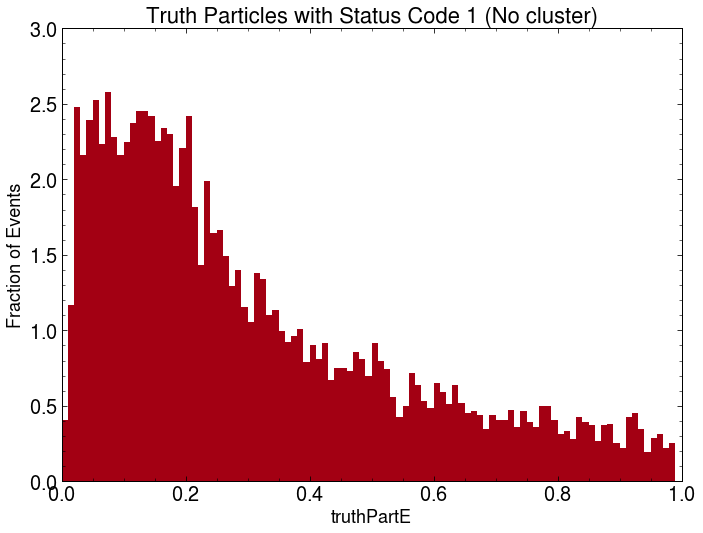

In [9]:
plt.hist(test["truthPartE"], bins = [x/100 for x in range(0, 100)], density=True)
plt.xlabel("truthPartE")
plt.ylabel("Fraction of Events")
plt.title("Truth Particles with Status Code 1 (No cluster)")
plt.axis([0, 1, 0, 3])

In [73]:
def geo_df_to_xyz(geo_df):
    """
    Adds xyz coordinates to geo_df
    
    Params:
        geo_df: pd.DataFrame 
    
    Returns:
        geo_df_with_xyz: pd.DataFrame original dataframe plus x y x coordinates for each cell
    
    """
    geo_df["cell_geo_x"] = geo_df["cell_geo_rPerp"] * np.cos(geo_df["cell_geo_phi"])
    geo_df["cell_geo_y"] = geo_df["cell_geo_rPerp"] * np.sin(geo_df["cell_geo_phi"])
    cell_geo_theta = 2 * np.arctan(np.exp(-geo_df["cell_geo_eta"]))
    geo_df["cell_geo_z"] = geo_df["cell_geo_rPerp"] / np.tan(cell_geo_theta)
    return geo_df

In [74]:
geo_df = geo_df_to_xyz(geo_df)

In [80]:
# throw out empty particles in out layer []

# check here for the old code of make_graph()
# https://github.com/evilpegasus/LCStudies/blob/cnn_dev/classifier/TopoClusterClassiferGraph.ipynb

def make_graph(event: pd.Series, geo_df: pd.DataFrame):
    """
    Creates a graph representation of an event
    
    inputs
    event (pd.Series) one event/row from EventTree
    geo_df (pd.DataFrame) the CellGeo DataFrame mapping cell_geo_ID to information about the cell
    
    returns
    A graph representation of the event for the GNN
    returns (None, None) if no cell energies detected
    """
    assert len(event["cluster_cell_E"]) == len(event["cluster_cell_ID"]), "Error: Missmatched len of cluster_cell_E and cluster_cell_ID"
    # If no energies were registered return tuple(None, Non)
    if len(event["cluster_cell_E"]) == 0:
        return None, None
    
    temp_df = geo_df[geo_df["cell_geo_ID"].isin([item for sublist in event["cluster_cell_ID"] for item in sublist])]
    temp_df = temp_df.set_index("cell_geo_ID")
    for cell_id, cell_e in zip(
        [item for sublist in event["cluster_cell_ID"] for item in sublist],
        [item for sublist in event["cluster_cell_E"] for item in sublist]
    ):
#         print(cell_id, cell_e)
        temp_df.loc[int(cell_id), "cell_E"] = cell_e
    
    # TODO make the graph from the df    
    
    
    n_nodes = temp_df.shape[0]
    
    
    # TODO reference for KNN search sklearn
    # https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
    # NOTE FAIR also has a faster algo for KNN search. Might want to try it    
    
    
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(temp_df[["cell_geo_x", "cell_geo_y", "cell_geo_z"]])
    distances, indices = nbrs.kneighbors(temp_df[["cell_geo_x", "cell_geo_y", "cell_geo_z"]])
    print(distances, indices)
    
    
    
    
#     input_datadict = {
#         "n_node": n_nodes,
#         "n_edge": n_edges,
#         "nodes": nodes,
#         "edges": edges,
#         "senders": senders,
#         "receivers": receivers,
#         "globals": np.array([n_nodes], dtype=np.float32)
#     }
#     target_datadict = {
#         "n_node": n_nodes,
#         "n_edge": n_edges,
#         "nodes": nodes,
#         "edges": edges,
#         "senders": senders,
#         "receivers": receivers,
#         "globals": np.array([event[solution]], dtype=np.float32)
#     }
#     input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
#     target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    
    return temp_df

In [81]:
temp_df = make_graph(df.iloc[1], geo_df)
temp_df

[[  0.          62.00256348  68.53453682  79.00110004  88.13665461]
 [  0.          67.99418309  70.31177727  76.02055822  79.9518475 ]
 [  0.          62.00256348  63.27844238  67.99425347  68.2172931 ]
 [  0.          63.27844238  64.59008789  68.03382228  68.14695449]
 [  0.          64.59008789  65.94506836  67.30704912  67.5405745 ]
 [  0.          65.94506836  66.35191773  66.64114087  67.09344456]
 [  0.          31.44360352  47.28381348  55.23339844  63.20251465]
 [  0.          15.84020996  23.78979492  31.44360352  31.75891113]
 [  0.           7.94958496  15.84020996  15.91870117  23.90869141]
 [  0.          15.95935059  31.99865723  40.04846191  48.11950684]
 [  0.           7.94958496   7.96911621  15.95910645  23.78979492]
 [  0.           7.96911621   7.98999023  15.91870117  15.99951172]
 [  0.          15.95935059  16.03930664  24.08911133  32.16015625]
 [  0.           7.98999023   8.00952148  15.95910645  16.03881836]
 [  0.           8.00952148   8.02929688  15.999

cell_geo_sampling  cell_geo_eta  cell_geo_phi  cell_geo_rPerp  \
cell_geo_ID                                                                  
754997258                    0     -1.112094      0.541559     1455.371704   
754997768                    0     -1.137005      0.443304     1455.587891   
754997770                    0     -1.137126      0.541559     1455.371704   
754998282                    0     -1.162158      0.541559     1455.371704   
754998794                    0     -1.187189      0.541559     1455.371704   
...                        ...           ...           ...             ...   
761277994                    3     -1.174946      0.529617     1890.635742   
761277996                    3     -1.174969      0.554177     1890.583252   
761277998                    3     -1.174991      0.578739     1890.531494   
761278506                    3     -1.224994      0.529610     1879.135742   
761278508                    3     -1.225018      0.554170     1879.083130   

             cell_geo_deta  cell_geo_dphi  cell_geo_volume  cell_geo_sigma  \
cell_geo_ID                                                                  
754997258            0.025       0.098175              0.0       37.354420   
754997768            0.025       0.098175              0.0       37.551403   
754997770            0.025       0.098175              0.0       37.551403   
754998282            0.025       0.098175              0.0       37.399971   
754998794            0.025       0.098175              0.0       37.505020   
...                    ...            ...              ...             ...   
761277994            0.050       0.024544        1433420.0       24.490633   
761277996            0.050       0.024544        1433420.0       24.490633   
761277998            0.050       0.024544        1433420.0       24.490633   
761278506            0.050       0.024544        1526180.0       25.832916   
761278508            0.050       0.024544        1526180.0       25.832916   

              cell_geo_x   cell_geo_y   cell_geo_z     cell_E  
cell_geo_ID                                                    
754997258    1247.117310   750.203552 -1973.375000   0.282466  
754997768    1314.889893   624.340210 -2035.378418   0.083780  
754997770    1247.117310   750.203552 -2035.377563  11.485039  
754998282    1247.117310   750.203552 -2098.656006   2.067950  
754998794    1247.117310   750.203552 -2163.246094   0.458767  
...                  ...          ...          ...        ...  
761277994    1631.619873   955.154541 -2768.959473   0.192079  
761277996    1607.626465   994.908081 -2768.960449   0.070131  
761277998    1582.664673  1034.060913 -2768.959717   0.018022  
761278506    1621.701904   949.333374 -2922.420410   0.028978  
761278508    1597.854370   988.845215 -2922.419922   0.025092  

[171 rows x 12 columns]

In [59]:
df.shape

(20000, 4)

In [40]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(temp_df[["cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp"]])
distances, indices = nbrs.kneighbors(temp_df[["cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp"]])

In [43]:
indices

array([[ 0, 12, 14,  6, 10],
       [ 1,  2,  3,  4,  5],
       [ 2,  1,  3,  4,  5],
       [ 3,  2,  1,  4,  5],
       [ 4,  5,  3,  7,  2],
       [ 5,  4,  7,  9,  3],
       [ 6, 12, 14,  5,  7],
       [ 7,  9,  5,  4, 10],
       [ 8, 16, 18,  7,  5],
       [ 9,  7, 10,  5, 11],
       [10,  9, 11,  7, 13],
       [11, 10, 13,  9, 15],
       [12, 14,  6, 11, 13],
       [13, 11, 15, 10, 17],
       [14, 12,  6, 13, 15],
       [15, 13, 17, 11, 19],
       [16, 18,  8, 15, 13],
       [17, 15, 19, 13, 20],
       [18, 16,  8, 17, 15],
       [19, 17, 20, 15, 13],
       [20, 19, 17, 15, 13],
       [21, 22, 20, 19, 17],
       [22, 21, 20, 19, 17],
       [23, 26, 29, 28, 25],
       [24, 25, 27, 28, 26],
       [25, 24, 28, 27, 26],
       [26, 29, 23, 28, 25],
       [27, 32, 25, 28, 30],
       [28, 25, 26, 27, 29],
       [29, 26, 28, 23, 25],
       [30, 31, 32, 27, 33],
       [31, 34, 30, 33, 32],
       [32, 27, 30, 31, 28],
       [33, 34, 31, 30, 35],
       [34, 31